<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="45%" align="right" border="4">

# Mean-Variance Portfolio Class

Without doubt, the Markowitz (1952) **mean-variance portfolio theory** is a cornerstone of modern financial theory. This section illustrates the use of the `mean_variance_portfolio` class to implement this approach.

In [1]:
from dx import *
from pylab import plt
plt.style.use('seaborn-v0_8')

## Market Environment and Portfolio Object

We start by instantiating a `market environment` object which in particular contains a list of **ticker symbols** in which we are interested in.

In [2]:
ma = market_environment('ma', dt.date(2010, 1, 1))
ma.add_list('symbols', ['AAPL.O', 'INTC.O', 'MSFT.O', 'GS.N'])
ma.add_constant('source', 'google')
ma.add_constant('final date', dt.date(2014, 3, 1))

Using pandas under the hood, the class **retrieves historial stock price data** from either Yahoo! Finance of Google.

In [3]:
%%time
port = mean_variance_portfolio('am_tech_stocks', ma)
  # instantiates the portfolio class
  # and retrieves all the time series data needed

CPU times: user 33.8 ms, sys: 10.7 ms, total: 44.5 ms
Wall time: 742 ms


In [4]:
port.get_available_symbols()

Index(['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'SPY', '.SPX', '.VIX',
       'EUR=', 'XAU=', 'GDX', 'GLD'],
      dtype='object')

## Basic Statistics

Since no **portfolio weights** have been provided, the class defaults to equal weights.

In [5]:
port.get_weights()
  # defaults to equal weights

{'AAPL.O': np.float64(0.25),
 'INTC.O': np.float64(0.25),
 'MSFT.O': np.float64(0.25),
 'GS.N': np.float64(0.25)}

Given these weights you can calculate the **portfolio return** via the method `get_portfolio_return`.

In [6]:
port.get_portfolio_return()
  # expected (= historical mean) return

np.float64(0.10783943504843156)

Analogously, you can call `get_portfolio_variance` to get the historical **portfolio variance**.

In [7]:
port.get_portfolio_variance()
  # expected (= historical) variance

np.float64(0.03452855260369096)

The class also has a neatly printable `string` representation.

In [8]:
print(port)
  # ret. con. is "return contribution"
  # given the mean return and the weight
  # of the security

Portfolio am_tech_stocks 
--------------------------
return            0.108
volatility        0.186
Sharpe ratio      0.580

Positions
symbol | weight | ret. con. 
--------------------------- 
AAPL.O |  0.250 |     0.045 
INTC.O |  0.250 |     0.024 
MSFT.O |  0.250 |     0.031 
GS.N   |  0.250 |     0.007 



## Setting Weights

Via the method `set_weights` the weights of the single portfolio components can be adjusted.

In [9]:
port.set_weights([0.6, 0.2, 0.1, 0.1])

In [10]:
print(port)

Portfolio am_tech_stocks 
--------------------------
return            0.143
volatility        0.202
Sharpe ratio      0.711

Positions
symbol | weight | ret. con. 
--------------------------- 
AAPL.O |  0.600 |     0.109 
INTC.O |  0.200 |     0.019 
MSFT.O |  0.100 |     0.012 
GS.N   |  0.100 |     0.003 



You cal also easily **check results for different weights** with changing the attribute values of an object.

In [11]:
port.test_weights([0.6, 0.2, 0.1, 0.1])
    # returns av. return + vol + Sharp ratio
    # without setting new weights

array([0.1434525 , 0.20175374, 0.71102774])

Let us implement a **Monte Carlo simulation** over potential portfolio weights.

In [12]:
# Monte Carlo simulation of portfolio compositions
rets = []
vols = []

for w in range(500):
    weights = np.random.random(4)
    weights /= sum(weights)
    r, v, sr = port.test_weights(weights)
    rets.append(r)
    vols.append(v)

rets = np.array(rets)
vols = np.array(vols)

And the simulation results **visualized**.

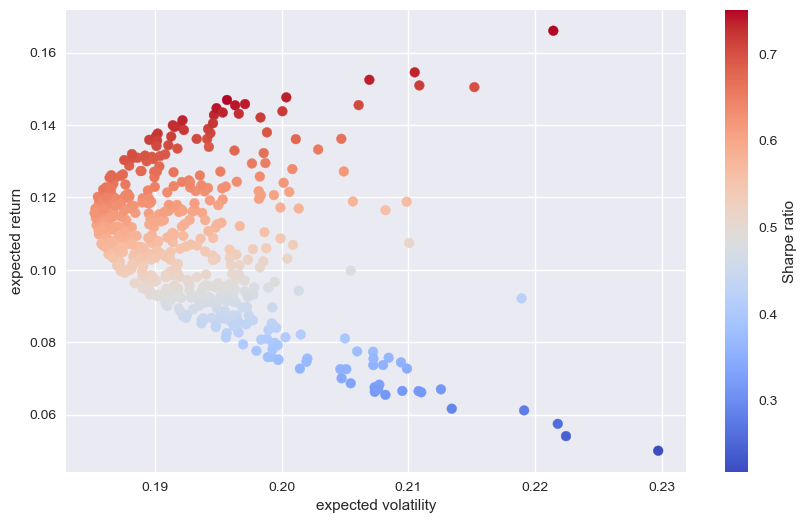

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.scatter(vols, rets, c=rets / vols, marker='o', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio');

## Optimizing Portfolio Composition

One of the major application areas of the mean-variance portfolio theory and therewith of this DX Analytics class it the **optimization of the portfolio composition**. Different target functions can be used to this end.

### Return

The first target function might be the **portfolio return**.

In [14]:
port.optimize('Return')
  # maximizes expected return of portfolio
  # no volatility constraint

In [15]:
print(port)

Portfolio am_tech_stocks 
--------------------------
return            0.181
volatility        0.253
Sharpe ratio      0.716

Positions
symbol | weight | ret. con. 
--------------------------- 
AAPL.O |  1.000 |     0.181 
INTC.O |  0.000 |     0.000 
MSFT.O |  0.000 |     0.000 
GS.N   |  0.000 |     0.000 



Instead of maximizing the portfolio return without any constraints, you can also set a (sensible/possible) **maximum target volatility** level as a constraint. Both, in an **exact sense** ("equality constraint") ...

In [16]:
port.optimize('Return', constraint=0.225, constraint_type='Exact')
  # interpretes volatility constraint as equality

In [17]:
print(port)

Portfolio am_tech_stocks 
--------------------------
return            0.071
volatility        0.225
Sharpe ratio      0.316

Positions
symbol | weight | ret. con. 
--------------------------- 
AAPL.O |  0.279 |     0.051 
INTC.O |  0.000 |     0.000 
MSFT.O |  0.000 |     0.000 
GS.N   |  0.721 |     0.021 



... or just a an **upper bound** ("inequality constraint").

In [18]:
port.optimize('Return', constraint=0.4, constraint_type='Bound')
  # interpretes volatility constraint as inequality (upper bound)

In [19]:
print(port)

Portfolio am_tech_stocks 
--------------------------
return            0.181
volatility        0.253
Sharpe ratio      0.716

Positions
symbol | weight | ret. con. 
--------------------------- 
AAPL.O |  1.000 |     0.181 
INTC.O |  0.000 |     0.000 
MSFT.O |  0.000 |     0.000 
GS.N   |  0.000 |     0.000 



### Risk

The class also allows you to minimize **portfolio risk**.

In [20]:
port.optimize('Vol')
  # minimizes expected volatility of portfolio
  # no return constraint

In [21]:
print(port)

Portfolio am_tech_stocks 
--------------------------
return            0.115
volatility        0.185
Sharpe ratio      0.619

Positions
symbol | weight | ret. con. 
--------------------------- 
AAPL.O |  0.263 |     0.048 
INTC.O |  0.240 |     0.023 
MSFT.O |  0.307 |     0.038 
GS.N   |  0.190 |     0.005 



And, as before, to set **constraints** (in this case) for the target return level.

In [22]:
port.optimize('Vol', constraint=0.175, constraint_type='Exact')
  # interpretes return constraint as equality

In [23]:
print(port)

Portfolio am_tech_stocks 
--------------------------
return            0.175
volatility        0.236
Sharpe ratio      0.740

Positions
symbol | weight | ret. con. 
--------------------------- 
AAPL.O |  0.888 |     0.161 
INTC.O |  0.000 |     0.000 
MSFT.O |  0.112 |     0.014 
GS.N   |  0.000 |     0.000 



In [24]:
port.optimize('Vol', constraint=0.10, constraint_type='Bound')
  # interpretes return constraint as inequality (upper bound)

In [25]:
print(port)

Portfolio am_tech_stocks 
--------------------------
return            0.115
volatility        0.185
Sharpe ratio      0.619

Positions
symbol | weight | ret. con. 
--------------------------- 
AAPL.O |  0.263 |     0.048 
INTC.O |  0.240 |     0.023 
MSFT.O |  0.307 |     0.038 
GS.N   |  0.190 |     0.005 



### Sharpe Ratio

Often, the target of the portfolio optimization efforts is the so called **Sharpe ratio**. The `mean_variance_portfolio` class of DX Analytics assumes a **risk-free rate of zero** in this context.

In [26]:
port.optimize('Sharpe')
  # maximize Sharpe ratio

In [27]:
print(port)

Portfolio am_tech_stocks 
--------------------------
return            0.160
volatility        0.208
Sharpe ratio      0.770

Positions
symbol | weight | ret. con. 
--------------------------- 
AAPL.O |  0.631 |     0.114 
INTC.O |  0.002 |     0.000 
MSFT.O |  0.367 |     0.046 
GS.N   |  0.000 |     0.000 



## Efficient Frontier

Another application area is to derive the **efficient frontier** in the mean-variance space. These are all these portfolios for which there is **no portfolio with both lower risk and higher return**. The method `get_efficient_frontier` yields the desired results.

In [28]:
%%time
evols, erets = port.get_efficient_frontier(100)
  # 100 points of the effient frontier

CPU times: user 1.05 s, sys: 2.15 ms, total: 1.05 s
Wall time: 1.05 s


The plot with the **random and efficient portfolios**.

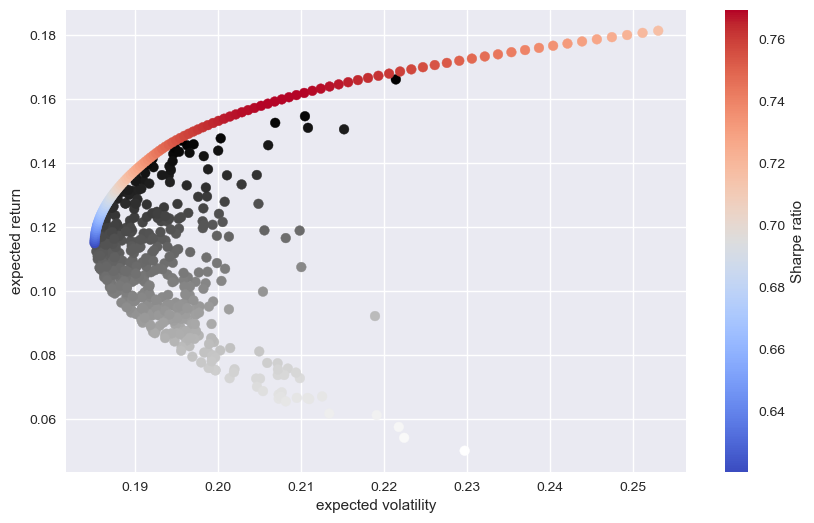

In [29]:
plt.figure(figsize=(10, 6))
plt.scatter(vols, rets, c=rets / vols, marker='o')
plt.scatter(evols, erets, c=erets / evols, marker='o', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

## Capital Market Line

The **capital market line** is another key element of the mean-variance portfolio approach representing all those risk-return combinations (in mean-variance space) that are possible to form from a **risk-less money market account** and **the market portfolio** (or another appropriate substitute efficient portfolio).

In [30]:
%%time
cml, optv, optr = port.get_capital_market_line(riskless_asset=0.05)
  # capital market line for effiecient frontier and risk-less short rate

CPU times: user 1.05 s, sys: 2.6 ms, total: 1.06 s
Wall time: 1.06 s


In [31]:
cml  # lambda function for capital market line

<function dx.portfolio.mean_variance_portfolio.get_capital_market_line.<locals>.<lambda>(x)>

The following plot illustrates that the capital market line has an ordinate value equal to the **risk-free rate** (the safe return of the money market account) and is tangent to the **efficient frontier**.

Text(0, 0.5, 'expected return')

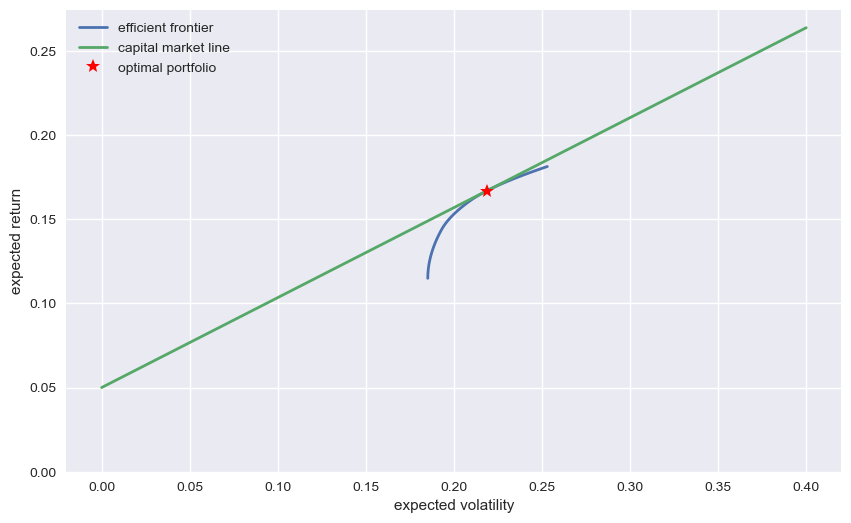

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(evols, erets, lw=2.0, label='efficient frontier')
plt.plot((0, 0.4), (cml(0), cml(0.4)), lw=2.0, label='capital market line')
plt.plot(optv, optr, 'r*', markersize=10, label='optimal portfolio')
plt.legend(loc=0)
plt.ylim(0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')

Portfolio return and risk of the efficient portfolio used are:

In [33]:
optr

0.16696367221604522

In [34]:
optv

0.21887664435943074

The **portfolio composition** can be derived as follows.

In [35]:
port.optimize('Vol', constraint=optr, constraint_type='Exact')

In [36]:
print(port)

Portfolio am_tech_stocks 
--------------------------
return            0.167
volatility        0.219
Sharpe ratio      0.763

Positions
symbol | weight | ret. con. 
--------------------------- 
AAPL.O |  0.746 |     0.135 
INTC.O |  0.000 |     0.000 
MSFT.O |  0.254 |     0.032 
GS.N   |  0.000 |     0.000 



Or also in this way.

In [37]:
port.optimize('Return', constraint=optv, constraint_type='Exact')

In [38]:
print(port)

Portfolio am_tech_stocks 
--------------------------
return            0.082
volatility        0.219
Sharpe ratio      0.375

Positions
symbol | weight | ret. con. 
--------------------------- 
AAPL.O |  0.351 |     0.064 
INTC.O |  0.000 |     0.000 
MSFT.O |  0.000 |     0.000 
GS.N   |  0.649 |     0.019 



## More Assets

As a larger, more realistic example, consider a larger set of assets.

In [39]:
symbols = list(port.get_available_symbols())[:7]
symbols

['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'SPY', '.SPX']

In [40]:
ma = market_environment('ma', dt.date(2010, 1, 1))
ma.add_list('symbols', symbols)
ma.add_constant('source', 'google')
ma.add_constant('final date', dt.date(2014, 3, 1))

**Data retrieval** in this case takes a bit.

In [41]:
%%time
djia = mean_variance_portfolio('djia', ma)
  # defining the portfolio and retrieving the data

CPU times: user 14.5 ms, sys: 4.62 ms, total: 19.1 ms
Wall time: 706 ms


In [42]:
%%time
djia.optimize('Vol')
print(djia.variance, djia.variance ** 0.5)
  # minimium variance & volatility in decimals

0.022043044780333063 0.14846900275927316
CPU times: user 29.2 ms, sys: 2.16 ms, total: 31.3 ms
Wall time: 31.2 ms


Given the larger data set now used, **efficient frontier** ...

In [43]:
%%time
evols, erets = djia.get_efficient_frontier(25)
  # efficient frontier of DJIA

CPU times: user 613 ms, sys: 2.54 ms, total: 616 ms
Wall time: 616 ms


... and **capital market line** derivations take also longer.

In [44]:
%%time
cml, optv, optr = djia.get_capital_market_line(riskless_asset=0.01)
  # capital market line and optimal (tangent) portfolio

CPU times: user 2.46 s, sys: 5.21 ms, total: 2.47 s
Wall time: 2.47 s


Text(0, 0.5, 'expected return')

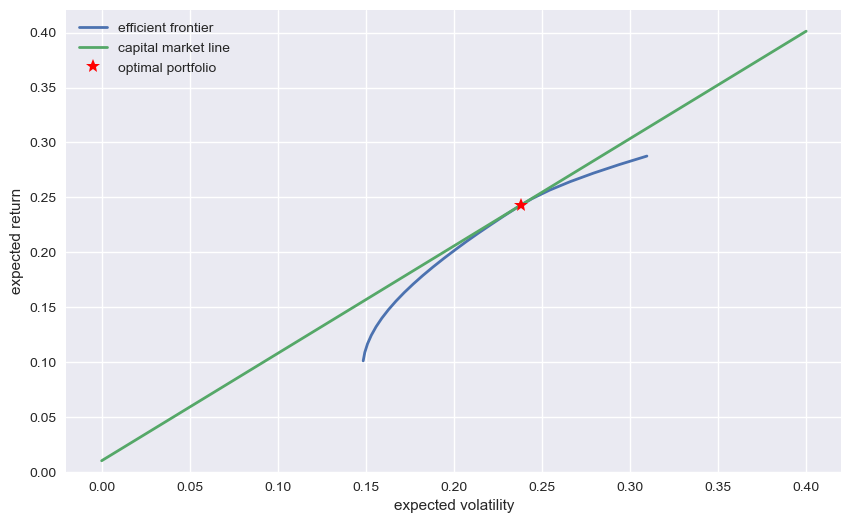

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(evols, erets, lw=2.0, label='efficient frontier')
plt.plot((0, 0.4), (cml(0), cml(0.4)), lw=2.0, label='capital market line')
plt.plot(optv, optr, 'r*', markersize=10, label='optimal portfolio')
plt.legend(loc=0)
plt.ylim(0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')

**Copyright, License & Disclaimer**

© Dr. Yves J. Hilpisch | The Python Quants GmbH

DX Analytics (the "dx library" or "dx package") is licensed under the GNU Affero General
Public License version 3 or later (see http://www.gnu.org/licenses/).

DX Analytics comes with no representations or warranties, to the extent
permitted by applicable law.

[Learn More & Stay in Touch](https://linktr.ee/dyjh)

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>